### 0. Imports

In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import random

### 1. Define parameters, initial conditions, and set up the cat situation

#### 1b. Randomize (or not)

In [193]:
mass_f = 0.5
mass_b = 0.5
cat_length = 0.5
cat_half_length = cat_length / 2
cat_radius = 0.05

Tc_initial = 2.0
theta_f_t0 = np.pi * (1 / 4)
theta_b_t0 = np.pi * (3 / 4)
omega_f_t0 = np.pi / 8
omega_b_t0 = 0
velocity_com = 0

height_com = 8
g = -9.81

In [286]:
T_restoring = 10
T_damping = 20

Mass:

Cats generally weigh around 5-15 pounds, so want front mass + back mass to fall in this range. We want them to be around equal, since it would be weird for the front half of a cat to be 10lbs, and the back to be 1lb, for example.

Length:

Cats are around 0.4-0.5 meters long, not counting the tail. I am not counting the tail in my project.

Supposedly need radius for moment of inertia? need to figure this out

Torque

This torque factor controls how quickly/forcefully the cat halves can rotate relative to each other. That is explained really badly, but a higher torque factor means it can rotate its body segments easily, but might have some over-rotation; and lower torque factor means the cat is slower at rotating body segments (not ideal for shorter heights).

Angles
* Want the angle (theta) values to be between 0 and pi. (Would choose -pi to pi or 0 to 2pi, but it shouldn't matter which left/right direction the cat is facing).

* Angular velocity can be in a range. It's very boring if both angular velocities are the same.

* Leave the velocity of center of mass as 0, otherwise you're not 'dropping' a cat, you're 'throwing' a cat

Gravity is going to be 9.81 on earth.


Time
* This can obviously be whatever we want the length of the fall to be.

In [287]:
def fall_time(h, g, v=0):
    """
    Calculate the time it takes for the cat to fall from a given height to the ground.
    """
    a = 0.5 * g
    b = v
    c = h
    
    # Solve using the quadratic formula: t = (-b ± sqrt(b^2 - 4ac)) / 2a
    discriminant = b**2 - (4 * a * c)
    
    if discriminant < 0:
        print(f"Warning: Negative discriminant for h={h}, g={g}, v={v}. Returning None.")
        return None  # Handle invalid cases gracefully
    
    time_to_fall = (- b - np.sqrt(discriminant)) / (2 * a)
    
    return time_to_fall


In [288]:
time_tot = fall_time(height_com, g, velocity_com)
print(time_tot)

1.277101713628202


Inertia
* Moments of inertia should be around 0.2 to 0.3 Some kind of paper on this.

#### 1c. Putting it all together

Constructing 'states' of cats and their conditions.

In [289]:
def create_cat(m_f=0.5, m_b=0.5, l=0.5, r=0.05):
    '''
    Creates a cat
    '''
    if type(m_f) == list:
        m_f = random.uniform(m_f[0], m_f[1])
    if type(m_b) == list:
        m_b = random.uniform(m_b[0], m_b[1])
    if type(l) == list:
        l = random.uniform(l[0], l[1])
    if type(r) == list:
        r = random.uniform(r[0], r[1])

    return m_f, m_b, l, r


def set_cat_conditions(T_coupling=2.0, theta_f=0, theta_b=(np.pi / 2), omega_f=(np.pi / 8), omega_b=0, v_com=0):
    """
    Sets up conditions like angle the cat is dropped from, and torque parameters.

    Inputs:
        T_coupling (float): Coupling torque constant.
        T_restoring (float): Restoring torque constant.
        Other inputs define initial angular and velocity conditions.
    """
    if type(T_coupling) == list:
        T_coupling = random.uniform(T_coupling[0], T_coupling[1])

    if type(theta_f) == list:
        theta_f = random.uniform(theta_f[0], theta_f[1])
    if type(theta_b) == list:
        theta_b = random.uniform(theta_b[0], theta_b[1])
    if type(omega_f) == list:
        omega_f = random.uniform(omega_f[0], omega_f[1])
    if type(omega_b) == list:
        omega_b = random.uniform(omega_b[0], omega_b[1])

    return T_coupling, theta_f, theta_b, omega_f, omega_b, v_com
    

def set_ext_conditions(t=2.0, h=8.0, g=-9.81):
    '''
    Non-cat parameters. How long the drop will take, the height of the drop, and gravity.
    '''
    if type(h) == list:
        h = random.uniform(h[0], h[1])

    return t, h, g

In [290]:
def create_state(cat, cat_initial_conditions, ext_initial_conditions):
    '''
    Creates an initial state. Information about cat and stuff so that we can see what happens when we drop a cat.
    Inputs:
        cat (list): [front mass, back mass, length, radius]
        cat_initial_conditions (list): [torque, front angle, back angle, front ang v, back ang v, com v]
        ext_initial_conditions (list): [time, height, gravity]
    Returns (list): state
    '''
    state = []
    state.extend(cat + cat_initial_conditions + ext_initial_conditions)

    return state


#### 1d. Actually making states to test

Designing my 'control' state, or the one I will use as an example and compare others to. 
Here I will try to just use basic boring parameters (so like an average weight cat, no starting velocity, nice starting angles, 9.81 gravity, etc.)

In [291]:
cat0 = create_cat(mass_f, mass_b, cat_length, cat_radius)
cat_conditions0 = set_cat_conditions(
    T_coupling=Tc_initial,
    theta_f=theta_f_t0, theta_b=theta_b_t0, 
    omega_f=omega_f_t0, omega_b=omega_b_t0, 
    v_com=velocity_com)
ext_conditions0 = set_ext_conditions(time_tot, height_com, g)

In [292]:
s = create_state(cat0, cat_conditions0, ext_conditions0)
print(s)
len(s)

[0.5, 0.5, 0.5, 0.05, 2.0, 0.7853981633974483, 2.356194490192345, 0.39269908169872414, 0, 0, 1.277101713628202, 8, -9.81]


13

Now, states for seeing how changing different variables affects things.

NEW cat, same cat conditions, same external conditions: 100

In [293]:
# Varying front weight - variable 1, code 1001
cat1 = create_cat(m_f=0.3, m_b=0.3, l=cat_length, r=cat_radius)
cat2 = create_cat(m_f=0.4, m_b=0.3, l=cat_length, r=cat_radius)
cat3 = create_cat(m_f=0.5, m_b=0.3, l=cat_length, r=cat_radius)
cat4 = create_cat(m_f=0.6, m_b=0.3, l=cat_length, r=cat_radius)
cat5 = create_cat(m_f=0.7, m_b=0.3, l=cat_length, r=cat_radius)

# Varying cat radius - variable 4, code 1004
cat6 = create_cat(m_f=mass_f, m_b=mass_b, l=cat_length, r=0.03)
cat7 = create_cat(m_f=mass_f, m_b=mass_b, l=cat_length, r=0.04)
cat8 = create_cat(m_f=mass_f, m_b=mass_b, l=cat_length, r=0.05)
cat9 = create_cat(m_f=mass_f, m_b=mass_b, l=cat_length, r=0.06)
cat10 = create_cat(m_f=mass_f, m_b=mass_b, l=cat_length, r=0.07)

same cat, NEW cat conditions, same external conditions: 010

In [294]:
# Change initial angles - variable 3, code 0103
# Keeping the front angle the same, varying the back angle
cat_conditions1 = set_cat_conditions(T_coupling=Tc_initial, theta_f=0, theta_b=0, 
                                     omega_f=omega_f_t0, omega_b=omega_b_t0, v_com=velocity_com)
cat_conditions2 = set_cat_conditions(T_coupling=Tc_initial, theta_f=0, theta_b=(np.pi * (1/4)), 
                                     omega_f=omega_f_t0, omega_b=omega_b_t0, v_com=velocity_com)
cat_conditions3 = set_cat_conditions(T_coupling=Tc_initial, theta_f=0, theta_b=(np.pi * (2/4)), 
                                     omega_f=omega_f_t0, omega_b=omega_b_t0, v_com=velocity_com)
cat_conditions4 = set_cat_conditions(T_coupling=Tc_initial, theta_f=0, theta_b=(np.pi * (3/4)), 
                                     omega_f=omega_f_t0, omega_b=omega_b_t0, v_com=velocity_com)
cat_conditions5 = set_cat_conditions(T_coupling=Tc_initial, theta_f=0, theta_b=(np.pi), 
                                     omega_f=omega_f_t0, omega_b=omega_b_t0, v_com=velocity_com)

# Change initial angles - variable 2, code 0102
# Changing both angles, but keeping cat aligned at start
cat_conditions6 = set_cat_conditions(T_coupling=Tc_initial, theta_f=0, theta_b=0, 
                                     omega_f=omega_f_t0, omega_b=omega_b_t0, v_com=velocity_com)
cat_conditions7 = set_cat_conditions(T_coupling=Tc_initial, theta_f=(np.pi / 2), theta_b=(np.pi / 2), 
                                     omega_f=omega_f_t0, omega_b=omega_b_t0, v_com=velocity_com)
cat_conditions8 = set_cat_conditions(T_coupling=Tc_initial, theta_f=(np.pi), theta_b=(np.pi), 
                                     omega_f=omega_f_t0, omega_b=omega_b_t0, v_com=velocity_com)

# Changging front angular velocity - variable 4, code 0104
cat_conditions9 = set_cat_conditions(T_coupling=Tc_initial, theta_f=theta_f_t0, theta_b=theta_b_t0, 
                                     omega_f=0, omega_b=0, v_com=velocity_com)
cat_conditions10 = set_cat_conditions(T_coupling=Tc_initial, theta_f=theta_f_t0, theta_b=theta_b_t0, 
                                      omega_f=(np.pi * (1/4)), omega_b=0, v_com=velocity_com)
cat_conditions11 = set_cat_conditions(T_coupling=Tc_initial, theta_f=theta_f_t0, theta_b=theta_b_t0, 
                                      omega_f=(np.pi * (1/2)), omega_b=0, v_com=velocity_com)
cat_conditions12 = set_cat_conditions(T_coupling=Tc_initial, theta_f=theta_f_t0, theta_b=theta_b_t0, 
                                      omega_f=(np.pi * (3/4)), omega_b=0, v_com=velocity_com)
cat_conditions13 = set_cat_conditions(T_coupling=Tc_initial, theta_f=theta_f_t0, theta_b=theta_b_t0, 
                                      omega_f=(np.pi), omega_b=0, v_com=velocity_com)


#change both angular velocities - variable 5, code 0105
cat_conditions14 = set_cat_conditions(T_coupling=Tc_initial, v_com=velocity_com, 
                                      theta_f=theta_f_t0, theta_b=theta_b_t0, omega_f=(np.pi * 0), omega_b=(np.pi * 0))
cat_conditions15 = set_cat_conditions(T_coupling=Tc_initial, v_com=velocity_com, 
                                      theta_f=theta_f_t0, theta_b=theta_b_t0, omega_f=(np.pi * (1/4)), omega_b=(np.pi * (0)))
cat_conditions16 = set_cat_conditions(T_coupling=Tc_initial, v_com=velocity_com, 
                                      theta_f=theta_f_t0, theta_b=theta_b_t0, omega_f=(np.pi * (0)), omega_b=(np.pi * (1/4)))
cat_conditions17 = set_cat_conditions(T_coupling=Tc_initial, v_com=velocity_com, 
                                      theta_f=theta_f_t0, theta_b=theta_b_t0, omega_f=(np.pi * (3/8)), omega_b=(np.pi * (-3/8)))
cat_conditions18 = set_cat_conditions(T_coupling=Tc_initial, v_com=velocity_com, 
                                      theta_f=theta_f_t0, theta_b=theta_b_t0, omega_f=(np.pi * 1/2), omega_b=(np.pi * -1/2))

same cat, same cat conditions, NEW external conditions: 001

This requires a note - This is the only area where we will have to think about different time scales. Changing either height or gravity should affect the time taken to fall. So we will need to re-set the time_tot variable.

In [295]:
# Vary height - variable 3, code 0013
h1, h2, h3, h4, h5 = 2, 4, 6, 8, 10
heights = [h1, h2, h3, h4, h5]

# Vary gravity - variable 2, code 0012
g_pluto = -0.62
g_moon = -1.62
g_mars = -3.73
g_earth = -9.81
g_jupiter = -24.79
gravities = [g_pluto, g_moon, g_mars, g_earth, g_jupiter]

In [296]:
# Calculate times
# Set up ext_condition
# Make state

h_states = []
for height in heights:
    t_h = fall_time(h=height, g=g_earth, v=velocity_com)
    ext_condition = set_ext_conditions(t=t_h, h=height, g=g_earth)
    state = create_state(cat0, cat_conditions0, ext_condition)
    h_states.append(state)

g_states = []
for gravity in gravities:
    t_g = fall_time(h=height_com, g=gravity, v=velocity_com)
    ext_condition = set_ext_conditions(t=t_g, g=gravity, h=height_com)
    state = create_state(cat0, cat_conditions0, ext_condition)
    g_states.append(state)

ALL the states

In [297]:
# Vary front mass
s10010 = create_state(cat1, cat_conditions0, ext_conditions0)
s10011 = create_state(cat2, cat_conditions0, ext_conditions0)
s10012 = create_state(cat3, cat_conditions0, ext_conditions0)
s10013 = create_state(cat4, cat_conditions0, ext_conditions0)
s10014 = create_state(cat5, cat_conditions0, ext_conditions0)
mf_states = [s10010, s10011, s10012, s10013, s10014]

# Vary radius
s10040 = create_state(cat6, cat_conditions0, ext_conditions0)
s10041 = create_state(cat7, cat_conditions0, ext_conditions0)
s10042 = create_state(cat8, cat_conditions0, ext_conditions0)
s10043 = create_state(cat9, cat_conditions0, ext_conditions0)
s10044 = create_state(cat10, cat_conditions0, ext_conditions0)
r_states = [s10040, s10041, s10042, s10043, s10044]

# Vary initial angles theta
s01030 = create_state(cat1, cat_conditions1, ext_conditions0)
s01031 = create_state(cat1, cat_conditions2, ext_conditions0)
s01032 = create_state(cat1, cat_conditions3, ext_conditions0)
s01033 = create_state(cat1, cat_conditions4, ext_conditions0)
s01034 = create_state(cat1, cat_conditions5, ext_conditions0)
s01020 = create_state(cat1, cat_conditions6, ext_conditions0)
s01021 = create_state(cat1, cat_conditions7, ext_conditions0)
s01022 = create_state(cat1, cat_conditions8, ext_conditions0)
# Separate or together depending how i decide to plot later
th1_states = [s01030, s01031, s01032, s01033, s01034]
th2_states = [s01020, s01021, s01022]
th_states = th1_states + th2_states

# Vary initial angular velocities omega
s01040 = create_state(cat0, cat_conditions9, ext_conditions0)
s01041 = create_state(cat0, cat_conditions10, ext_conditions0)
s01042 = create_state(cat0, cat_conditions11, ext_conditions0)
s01043 = create_state(cat0, cat_conditions12, ext_conditions0)
s01044 = create_state(cat0, cat_conditions13, ext_conditions0)
om1_states = [s01040, s01041, s01042, s01043, s01044]

s01050 = create_state(cat0, cat_conditions14, ext_conditions0)
s01051 = create_state(cat0, cat_conditions15, ext_conditions0)
s01052 = create_state(cat0, cat_conditions16, ext_conditions0)
s01053 = create_state(cat0, cat_conditions17, ext_conditions0)
s01054 = create_state(cat0, cat_conditions18, ext_conditions0)
om2_states = [s01050, s01051, s01052]

# Vary drop height
s00130 = h_states[0]
s00131 = h_states[1]
s00132 = h_states[2]
s00133 = h_states[3]
s00134 = h_states[4]

# Vary gravity
s00120 = g_states[0]
s00121 = g_states[1]
s00122 = g_states[2]
s00123 = g_states[3]
s00124 = g_states[4]

In [298]:
mf_labels = ["Front mass = 0.3", "0.4", "0.5", "0.6", "0.7"]

r_labels = ["Radius = 0.3", "0.4", "0.5", "0.6", "0.7"]

th1_labels = ["θ_f, θ_b = 0, 0", "θ_f, θ_b = 0, π/4", "θ_f, θ_b = 0, π/2", "θ_f, θ_b = 0, 3π/4", "θ_f, θ_b = 0, π"]
th2_labels = ["θ_f, θ_b = 0, 0", "θ_f, θ_b = π/2, π/2", "θ_f, θ_b = π, π"]
th_labels = th1_labels + th2_labels

om1_labels = ["ω_f = 0", "ω_f = π/4", "ω_f = π/2", "ω_f = 3π/4", "ω_f = π"]
om2_labels = ["ω_f,ω_b = 0", "ω_f,ω_b = pm π/4", "ω_f,ω_b = pm π/2"]

h_labels = ["Height=2", "4", "6", "8", "10"]

g_labels = ["Gravity on Pluto", "Moon", "Mars", "Earth", "Jupiter"]

So for my refererence:

* mf_states --> varying front mass
* r_states --> varying radius (fatness)
* th_states --> varying angle; th1 is varying one angle, th2 is varying both but keeping them matched
* om_states --> varying angular velocity
* h_states --> varying drop height
* g_states --> varying gravity

### 

2. Equations of Motion

#### 2a. Some general stuff

In [299]:
def cat_aligned(theta1, theta2, threshold):
    '''
    Determines if the cat is aligned enough or if it needs to rotate more
    '''
    angle = abs(theta1 - theta2)

    if angle > threshold:
        return True
    else:
        return False

In [300]:
def cat_half_upright(angle, allowance):
    '''
    Determines if a half of the cat is 'upright', which is defined being within a range of angle 0.
    '''
    upright_angle = np.pi / 2
    
    lb = upright_angle - allowance
    ub = upright_angle + allowance
    
    if lb <= angle <= ub:
        return True
    else:
        return False

In [301]:
def inertia(t, theta_f, theta_b):
    """
    Calculate moments of inertia for front and back halves.
    """
    I0_f = (1 / 2) * mass_f * cat_radius**2
    I0_b = (1 / 2) * mass_b * cat_radius**2

    # Adjust based on angular positions
    front_factor = 1.0 if cat_half_upright(theta_f, np.pi/8) else 1.4
    back_factor = 1.0 if cat_half_upright(theta_f, np.pi/8) else 1.4

    # Ensure inertia is nonzero
    I_f = max(I0_f * front_factor, 1e-6)
    I_b = max(I0_b * back_factor, 1e-6)

    return I_f, I_b


Important! These are the important equations.

In [302]:
#state = m_f, m_b, l, r, Tc, th_f, th_b, om_f, om_b, v_com, t, h, g

def equations(t, state):
    """
    Calculate derivatives for the cat's motion.
    """
    # Manually unpack state
    mass_f, mass_b, cat_length, radius, T_coupling, theta_f, theta_b, omega_f, omega_b, v_com, time_tot, y_com, gravity = state

    # Calculate moments of inertia
    I_f, I_b = inertia(t, theta_f, theta_b)

    # Coupling torque to align front and back halves
    coupling_torque = -T_coupling * (theta_f - theta_b)

    # Restoring torques
    restoring_torque_f = -T_restoring * (theta_f - (np.pi / 2)) + coupling_torque
    restoring_torque_b = -T_restoring * (theta_b - (np.pi / 2)) - coupling_torque

    # Angular accelerations with damping
    domega_f_dt = (restoring_torque_f / I_f) - T_damping * omega_f
    domega_b_dt = (restoring_torque_b / I_b) - T_damping * omega_b

    # Angular velocities
    dtheta_f_dt = omega_f
    dtheta_b_dt = omega_b

    # Center of mass dynamics (parabolic trajectory)
    dv_com_dt = gravity
    dy_com_dt = v_com

    return [
        0,  # mass_f (fixed)
        0,  # mass_b (fixed)
        0,  # cat_length (fixed)
        0,  # radius (fixed)
        0,  # T_coupling (fixed)
        dtheta_f_dt,  # θ_f
        dtheta_b_dt,  # θ_b
        domega_f_dt,  # ω_f
        domega_b_dt,  # ω_b
        dv_com_dt,    # v_com
        0,  # time_tot (fixed)
        dy_com_dt,    # y_com
        0   # gravity (fixed)
    ]


#### 2b. Using solve_ivp

#### 2c. Using Runge-Kutta 

In [303]:
time_range = (0, time_tot)
dt = 0.001


In [304]:
def rk4_solver(equations, t_span, state, dt):
    """
    Implements the Runge-Kutta 4th order method for solving ODEs with the full state vector.
    """
    t0, t_end = t_span
    n_steps = int((t_end - t0) / dt) + 1
    time = np.linspace(t0, t_end, n_steps)

    # Allocate space for the full state vector
    states = np.zeros((n_steps, len(state)))
    states[0] = state  # Initial state

    # RK4 Integration Loop
    for i in range(1, n_steps):
        t = time[i - 1]
        y = states[i - 1]

        # Compute RK4 increments
        k1 = np.array(equations(t, y))
        k2 = np.array(equations(t + dt / 2, y + dt / 2 * k1))
        k3 = np.array(equations(t + dt / 2, y + dt / 2 * k2))
        k4 = np.array(equations(t + dt, y + dt * k3))

        # Update the full state
        states[i] = y + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

    return time, states


### 3. Extracting values, doing calculations, creating plot functions (but not plots)

#### 


3a. Extract values

For single state, s (state0)

In [305]:
def solve_states(states, dt=0.01):
    """
    Solve equations of motion for a list of states and extract key variables.
    
    Inputs:
        states (list): List of initial states.
        dt (float): Time step for RK4 solver.
    
    Returns:
        results (dict): Contains solutions for all states, including:
            - "time": Shared time array.
            - "theta_f", "theta_b": Orientation angles.
            - "omega_f", "omega_b": Angular velocities.
            - "y_com_tot", "y_com_f", "y_com_b": Heights.
            - "diff_y_f", "diff_y_b": Relative COM positions.
    """
    results = {
        "time": None,
        "theta_f": [],
        "omega_f": [],
        "theta_b": [],
        "omega_b": [],
        "y_com_tot": [],
        "y_com_f": [],
        "y_com_b": [],
        "diff_y_f": [],
        "diff_y_b": [],
    }
    
    for i, state in enumerate(states):
        # Extract parameters
        mass_f, mass_b, cat_length, _, _, theta_f0, theta_b0, omega_f0, omega_b0, v_com0, time_tot, y_com0, gravity = state
        cat_half_length = cat_length / 2

        # Solve ODEs
        time, state_data = rk4_solver(equations, (0, time_tot), state, dt)

        # Ensure state_data structure
        assert state_data.shape[1] >= 12, "State data does not have expected number of variables."

        # Extract dynamic variables
        theta_f = state_data[:, 5]
        omega_f = state_data[:, 7]
        theta_b = state_data[:, 6]
        omega_b = state_data[:, 8]
        y_com = state_data[:, 11]

        # Compute COM positions
        y_com_f = y_com - (cat_half_length / 2) * np.cos(theta_f)
        y_com_b = y_com - (cat_half_length / 2) * np.cos(theta_b)
        y_com_tot = ((y_com_f * mass_f) + (y_com_b * mass_b)) / (mass_f + mass_b)

        # Compute relative COM differences
        diff_y_f = y_com_tot - y_com_f
        diff_y_b = y_com_tot - y_com_b

        # Store results
        if i == 0:
            results["time"] = time
        results["theta_f"].append(theta_f)
        results["omega_f"].append(omega_f)
        results["theta_b"].append(theta_b)
        results["omega_b"].append(omega_b)
        results["y_com_tot"].append(y_com_tot)
        results["y_com_f"].append(y_com_f)
        results["y_com_b"].append(y_com_b)
        results["diff_y_f"].append(diff_y_f)
        results["diff_y_b"].append(diff_y_b)

    return results


In [306]:
results = solve_states([s])

#### 3b. Setting up functions to make plots

make_plot is a general function to make all the individual plots. This way they look the same, and are easy to change if I need

In [307]:
def make_single_plot(x, y, titles, labels, colors, zeroline=False):
    '''
    Makes a plot of what I want.

    Input:
        x
        y (list)
        titles (list)
        labels (list)
        colors (list)
        zeroline (bool)
    '''
    plt.figure(figsize=(10,6))
    num_plots = len(y)

    # Do the titles
    plt.title(titles[0], fontsize=20)
    plt.xlabel(titles[1], fontsize=18)
    plt.ylabel(titles[2], fontsize=18)

#    For the sine graphs
#    plt.ylim(-1, 1)

    # Make the plot
    for i in range(num_plots):
        plt.plot(x, y[i], label=labels[i], color=colors[i])

    if zeroline:
        plt.hlines(0, x[0], x[-1], label='Whole Cat', color=color_cat)
    
    # Other
    plt.grid()
    plt.legend(loc="best", fontsize=14)

In [308]:
def make_multi_plot(x, y, titles, labels, colors, zeroline=False, x_limit=None, com=False, statelabels=None):
    '''
    Plot multiple lines on a single plot.

    Inputs:
        x (array): Shared x-axis array (e.g., time).
        y (list of arrays): List of y-axis arrays (e.g., y_com_tot for different states).
        titles (list): [Title, X-axis label, Y-axis label].
        labels (list): Labels for each line (e.g., ["State A", "State B", ...]).
        colors (list): List of colors for each line.
        zeroline (bool): If True, adds a horizontal line at y=0.
        x_limit (tuple): Tuple specifying (xmin, xmax) for the x-axis.
    '''
    plt.figure(figsize=(10, 6))

    # Plot lines
    if com:
        for i in range(len(y)):
            plt.plot(x, y[i], label=labels[i], color=colors[i], alpha=1)
    else:
        for i in range(len(y)):
            plt.plot(x, y[i], label=(labels[i] if (i%2==1) else None), color=colors[i], alpha=0.6)

    # for sine
    #plt.ylim(-1.1, 1.1)
    
    # Add zero line if requested
    if zeroline:
        plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

    # Titles and labels
    plt.title(titles[0], fontsize=20)
    plt.xlabel(titles[1], fontsize=18)
    plt.ylabel(titles[2], fontsize=18)

    # Grid, legend, and show
    plt.grid()
    plt.legend(loc="best", fontsize=14)
    plt.show()


In [309]:
def get_timescale(states, gravity_index=-2, height_index=-1):
    return max(fall_time(state[height_index], state[gravity_index]) for state in states)

plot_single_state is to create a bunch of plots to show different aspects of one state. To create a baseline idea of what we're looking for, and check that code is working as I expect.

In [310]:
def plot_single_state(state, plot_information):
    """
    For a given initial state, creates plots by solving equations of motion.
    
    Inputs:
        state (list): list of [cat + cat_initial_conditions + ext_initial_conditions].
        plot_information (list): list of plot information, including titles, labels, colors.
    """
    # Extract variables from state
    mass_f, mass_b, cat_length, _, T_coupling, theta_f0, omega_f0, theta_b0, omega_b0, v_com0, time_tot, y_com0, gravity = state
    cat_half_length = cat_length / 2

    # Solve ODEs using rk4_solver
    time, state_data = rk4_solver(equations, (0, time_tot), state, dt)

    # Extract dynamic variables from state_data
    theta_f = state_data[:, 5]  # 5th variable: theta_f
    omega_f = state_data[:, 7]  # 6th variable: omega_f
    theta_b = state_data[:, 6]  # 7th variable: theta_b
    omega_b = state_data[:, 8]  # 8th variable: omega_b
    y_com = state_data[:, 11]    # 9th variable: y_com

    # Calculate COM positions
    y_com_f = y_com - (cat_half_length / 2) * np.cos(theta_f)
    y_com_b = y_com - (cat_half_length / 2) * np.cos(theta_b)
    y_com_tot = ((y_com_f * mass_f) + (y_com_b * mass_b)) / (mass_f + mass_b)

    # And differences
    diff_y_f = y_com_tot - y_com_f
    diff_y_b = y_com_tot - y_com_b

    # Extract details from plot information
    com_info = plot_information[0]
    com_info_segment = plot_information[1]
    angle_info = plot_information[2]
    sine_info = plot_information[3]

    # Plot: Center of Mass Heights
    make_single_plot(time, [y_com_f, y_com_b, y_com_tot], titles=com_info[0], labels=com_info[1], colors=com_info[2])

    # Plot: Relative COM Positions
    make_single_plot(time, [diff_y_f, diff_y_b], com_info_segment[0], com_info_segment[1], com_info_segment[2], zeroline=True)
    
    # Plot: Orientation Angles
    make_single_plot(time, [theta_f, theta_b], titles=angle_info[0], labels=angle_info[1], colors=angle_info[2])

    # Plot: Sine of orientation angle
    sine_theta_f = np.sin(theta_f)
    sine_theta_b = np.sin(theta_b)
    make_single_plot(time, [sine_theta_f, sine_theta_b], titles=sine_info[0], labels=sine_info[1], colors=sine_info[2])


In [311]:
def plot_multi_states(states, main_titles, x_labels, y_labels, colors, state_labels, dt=0.01):
    '''
    For a given list of states, solves the equations of motion and creates three comparative plots:
    1. Center of Mass Heights Over Time
    2. Relative Vertical Positions of Front and Back Halves Relative to Overall COM
    3. Orientation Angles of Front and Back Halves Over Time

    Inputs:
        states (list): List of initial states.
        main_titles (list): Titles for the three plots (e.g., ["Overall COM", "Relative COM", "Angles"]).
        x_labels (list): X-axis labels for the three plots.
        y_labels (list): Y-axis labels for the three plots.
        colors (list): List of three lists of colors for the three plots (one list of colors per plot).
        state_labels (list): Labels for each state (e.g., ["State A", "State B", "State C"]).
        dt (float): Time step size for RK4 solver.
    '''
    
    # Solve equations for all states
    results = solve_states(states, dt)

    # Fix time problems for heights and gravity states
    if states == g_states or states == h_states:
        x_scale = get_timescale(states)

    # Ensure y-data arrays are 2D with shape (num_states, num_time_steps)
    y_com_tot = np.array(results["y_com_tot"])  # (num_states, num_time_steps)
    diff_y_f = np.array(results["diff_y_f"])
    diff_y_b = np.array(results["diff_y_b"])
    theta_f = np.array(results["theta_f"])
    theta_b = np.array(results["theta_b"])
    sine_theta_f = np.sin(theta_f)
    sine_theta_b = np.sin(theta_b)

    # Plot: Center of Mass Heights
    make_multi_plot(
        x=results["time"],  # 1D array of time
        y=y_com_tot,  # 2D array, rows = states
        titles=[main_titles[0], x_labels[0], y_labels[0]],
        labels=state_labels,
        colors=colors[0],
        x_limit=x_scale if (states == g_states or states == h_states) else None,
        com=True
    )

    # Plot: Relative COM Positions
    y_combined = np.concatenate([diff_y_b, diff_y_f], axis=0)  # Stack front and back COM differences
    combined_labels = state_labels + state_labels  # Double labels for front/back

    make_multi_plot(
        x=results["time"],
        y=y_combined,  # Combined front and back differences
        titles=[main_titles[1], x_labels[1], y_labels[1]],
        labels=combined_labels,
        colors=colors[1],
        zeroline=True,
        x_limit=x_scale if (states == g_states or states == h_states) else None,
        com=False
    )

    # Plot: Orientation Angles
    y_combined = np.concatenate([theta_b, theta_f], axis=0)  # Stack front and back angles
    combined_labels = state_labels + state_labels

    make_multi_plot(
        x=results["time"],
        y=y_combined,
        titles=[main_titles[2], x_labels[2], y_labels[2]],
        labels=combined_labels,
        colors=colors[2],
        x_limit=x_scale if (states == g_states or states == h_states) else None,
        com=False
    )

    # Plot: Sine of Orientation Angles
    sine_combined = np.concatenate([sine_theta_f, sine_theta_b], axis=0)

    make_multi_plot(
        x=results["time"],
        y=sine_combined,
        titles=[main_titles[3], x_labels[3], y_labels[3]],
        labels=combined_labels,
        colors=colors[3],
        x_limit=x_scale if (states == g_states or states == h_states) else None,
        com=False,
        zeroline=False
    )


### 4. Plots Plots Plots

#### 4a. For just one state, s

In [312]:
color_front = 'mediumvioletred'
color_back = 'plum'
color_cat = 'black'

In [313]:
# Extract data for plotting
time = results["time"]  # Shared time array
y_com_state0 = results["y_com_tot"]
theta_f_state0 = results["theta_f"]
theta_b_state0 = results["theta_b"]

In [314]:
state_s_plot_information = [
    [["Center of Mass Height Over Time", "Time (s)", "Center of Mass Height (m)"],
     ["Front Half COM", "Back Half COM", "Whole Cat COM"],
     [color_front, color_back, color_cat]],
    [["Center of Mass of Segments Relative to Overall", "Time (s)", "Centers of Mass Heights (m)"],
     ["Front Half Relative to COM", "Back Half Relative to COM"],
     [color_front, color_back]],
    [["Orientation Angles of Cat Segments Over Time", "Time (s)", "Orientation Angle (rad)"],
     ["Front Half Orientation (θ_f)", "Back Half Orientation (θ_b)"],
     [color_front, color_back]],
    [["Sine of Orientation Angles Over Time", "Time (s)", "Sine of Orientation Angle"],
     ["sin(θ_f)", "sin(θ_b)"],
     [color_front, color_back]]  # New plot info for sine values
]


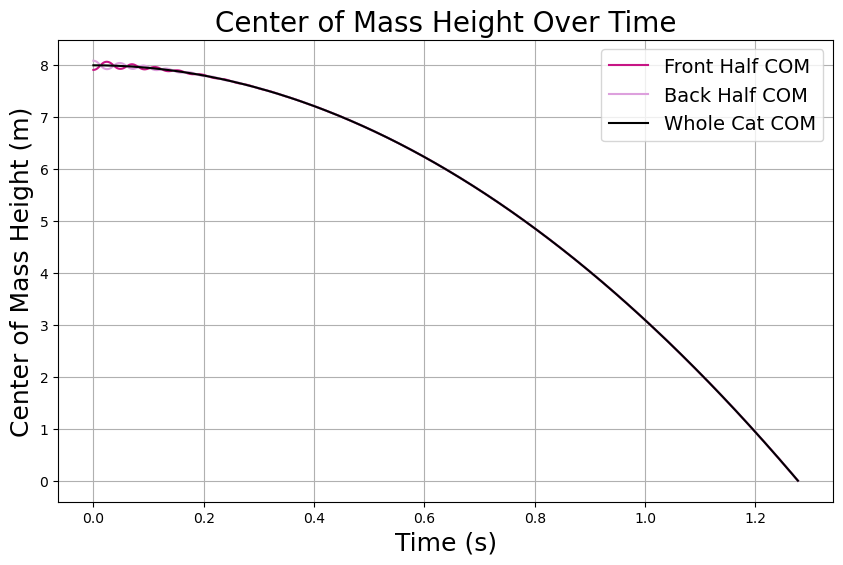

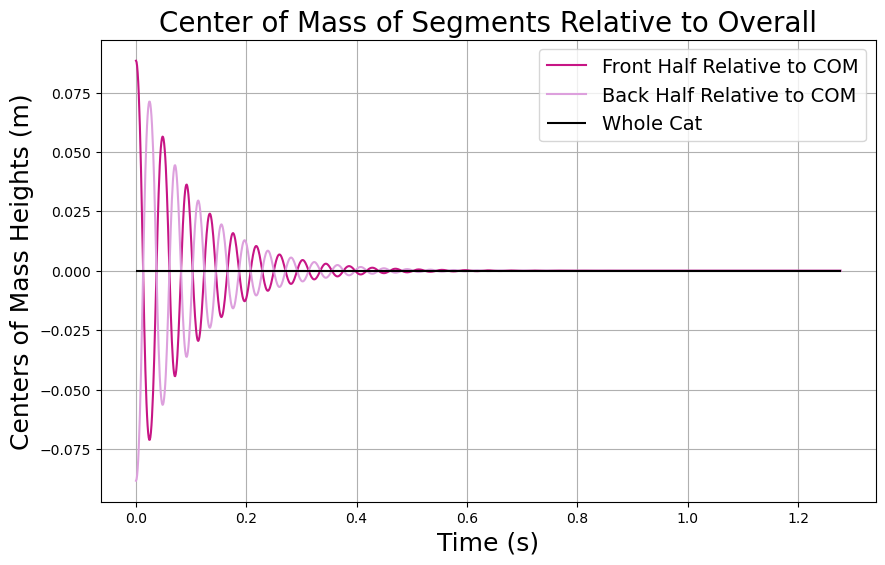

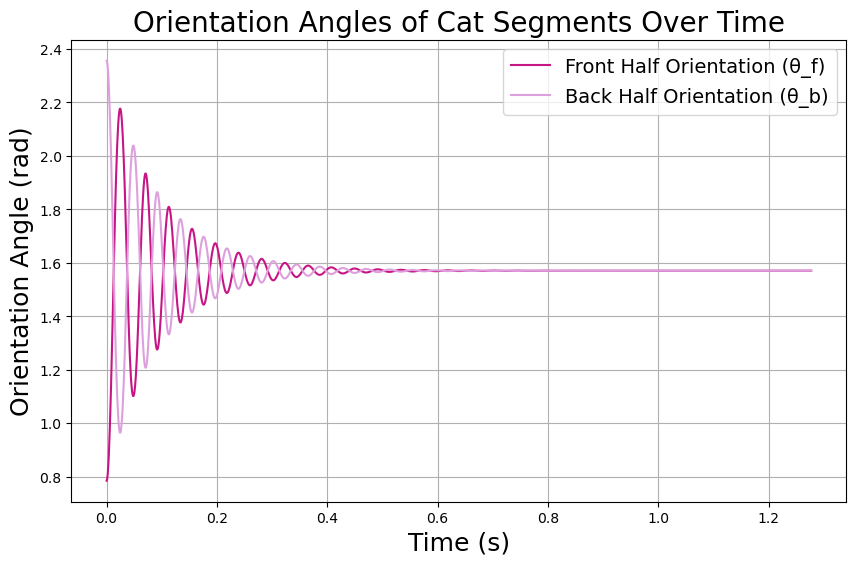

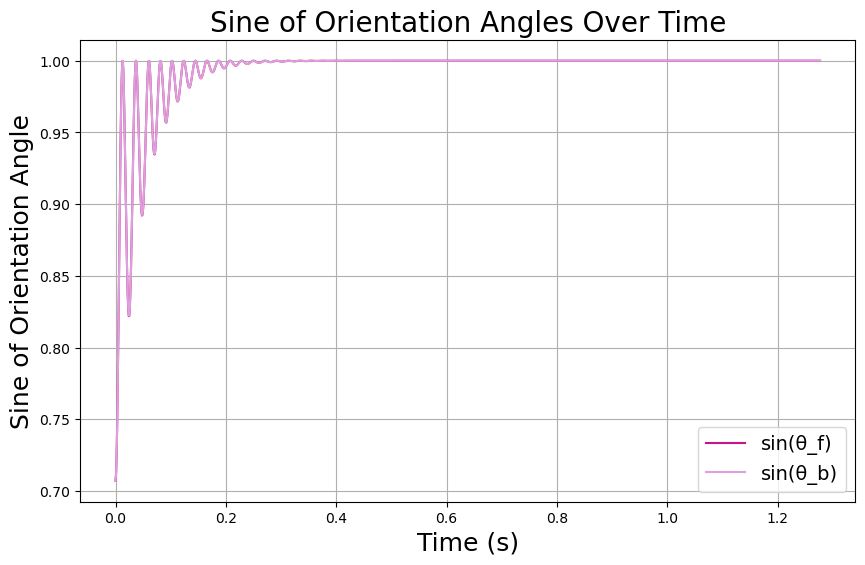

In [315]:
plot_single_state(s, state_s_plot_information)

#### 4b. Do multiple states, varying different variables

Set up colors

In [316]:
s3 = ['orangered', 'green', 'deepskyblue']
d3 = ['lightsalmon', 'orangered', 
      'yellowgreen', 'green', 
      'powderblue', 'deepskyblue']
colors3 = [s3, d3, d3, d3]

s5 = ['orangered', 'darkorange', 'gold', 'green', 'deepskyblue']
d5 = ['lightsalmon', 'orangered', 
      'navajowhite', 'darkorange', 
      'lemonchiffon', 'gold', 
      'lightgreen', 'green', 
      'powderblue', 'deepskyblue']
colors5 = [s5, d5, d5, d5]

s9 = ['red', 'orangered', 'darkorange', 'gold', 'yellowgreen', 'green', 'deepskyblue', 'royalblue', 'darkorchid']
d9 = ['lightcoral', 'red', 
      'lightsalmon', 'orangered', 
      'navajowhite', 'darkorange', 
      'lemonchiffon', 'gold', 
      'yellowgreen', 'olivedrab', 
      'green', 'lightgreen',
      'powderblue', 'deepskyblue', 
      'lightsteelblue', 'royalblue', 
      'orchid', 'darkorchid']
colors9 = [s9, d9, d9, d9]

Set up titles

In [128]:
main_titles = ["Center of Mass Height Over Time", 
               "COM of Segments Relative to Whole Cat COM", 
               "Orientation Angles of Cat Segments", 
               "Sine of Orientation Angles of Cat Segments"]
x_labels = ["Time (s)"] * 4
y_labels = ["Center of Mass Height (m)", "Centers of Mass Displacements (m)", "Orientation Angle (rad)", "Sine of Orientation Angle"]

Copied from above as a reminder:

* mf_states --> varying front mass
* r_states --> varying radius (fatness)
* th_states --> varying angle; th1 is varying one angle, th2 is varying both but keeping them matched
* om_states --> varying angular velocity
* h_states --> varying drop height
* g_states --> varying gravity

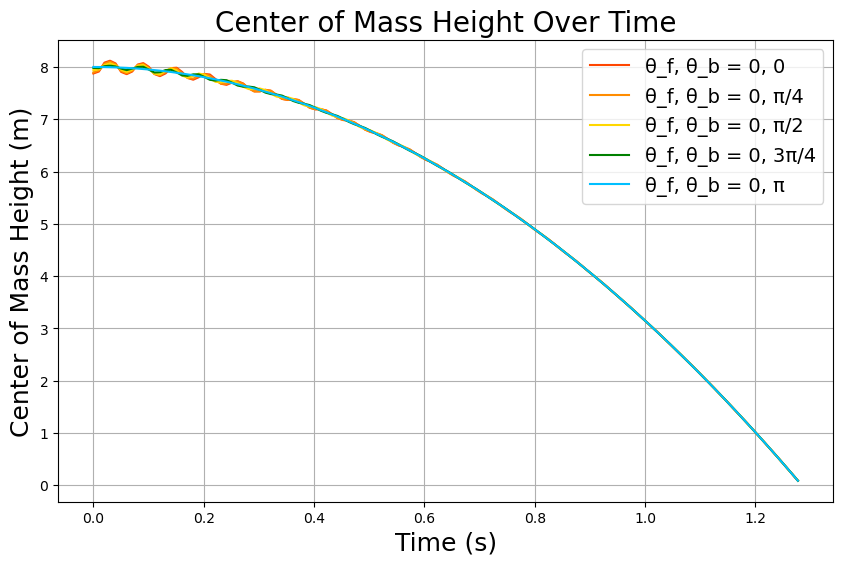

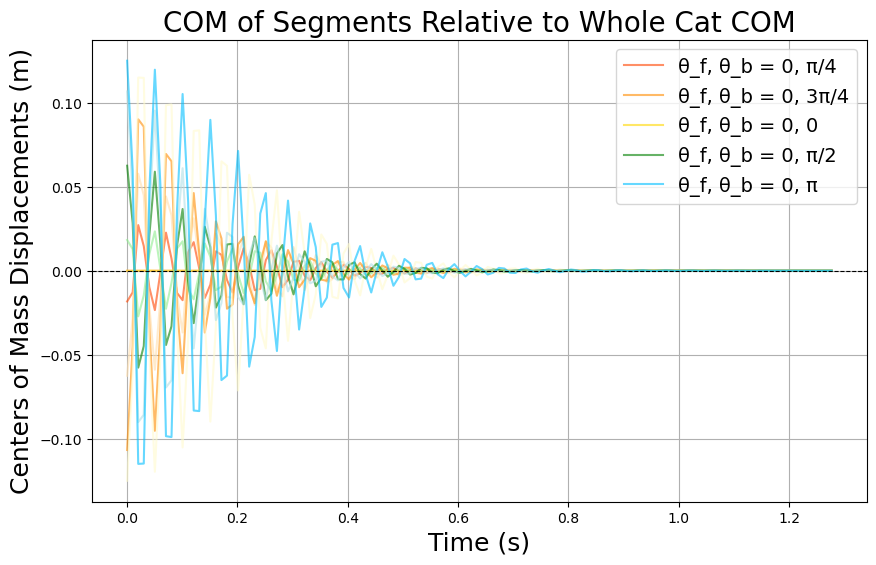

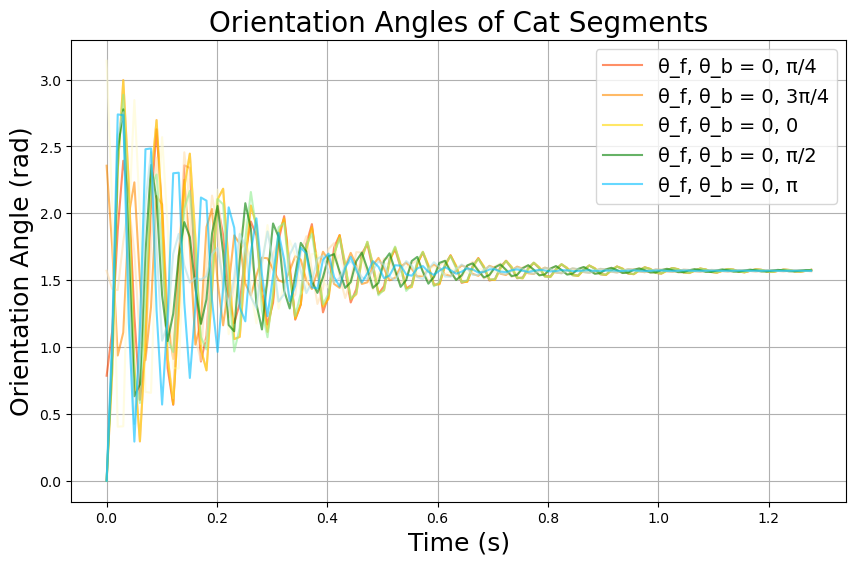

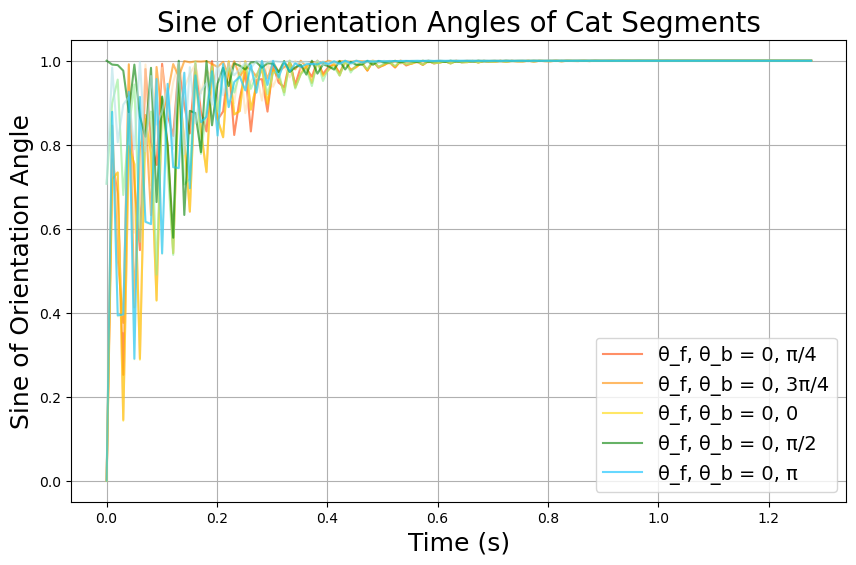

In [129]:
# Plot the multiple states
plot_multi_states(th1_states, main_titles, x_labels, y_labels, colors5, th1_labels)

## Code that i want to save just in case but probably should delete